# 几何基础
三维数据基础，包括点云、mesh、深度图、KD树

- 官方文档地址：http://www.open3d.org/docs/release/tutorial/geometry/pointcloud.html
- o3d.data数据集抽风，我直接把用到的给下下来了
- colab不支持open3d三维可视化，jupyter notebook本地运行可视化是弹窗显示

In [1]:
import open3d as o3d
import open3d_example as o3de
import numpy as np
import copy,time,re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 点云处理
### 读取 展示

In [2]:

# 读取 展示
datadir = "PointCloudData\\yk_examples\\rectangle.ply"
pcd = o3d.io.read_point_cloud(datadir)
print(pcd)
print(np.asarray(pcd.points))
print(np.asarray(pcd.points).shape)

# 弹窗"Ctrl+C"可以复制参数，粘贴即可得到缩放、视角之类的东西
o3d.visualization.draw_geometries([pcd],mesh_show_wireframe=True)

PointCloud with 43381 points.
[[-0.01911783 -0.03290318  0.98277861]
 [-0.01802992 -0.03287225  0.98180258]
 [-0.01769577 -0.03290823  0.98286402]
 ...
 [ 0.02130458  0.07828158  0.98029351]
 [ 0.0216579   0.07827332  0.98019391]
 [ 0.02201807  0.0782923   0.98043334]]
(43381, 3)


### 下采样 法线估计

In [ ]:
# 下采样
downpcd = pcd.voxel_down_sample(voxel_size = 0.001)
# 法线估计，按“N”查看法线，不计算也能直接显示法线
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# np.asarray(downpcd.normals).shape
# o3d.visualization.draw_geometries([downpcd])

### 裁剪

In [3]:
# 裁剪
pcd = o3d.io.read_point_cloud("PointCloudData\\isl-org_examples\\fragment.ply")
vol = o3d.visualization.read_selection_polygon_volume("PointCloudData\\isl-org_examples\\cropped.json")
chair = vol.crop_point_cloud(pcd)
o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,                             # 相机变焦
                                  front=[0.5439, -0.2333, -0.8060],     # 相机矢量
                                  lookat=[2.4615, 2.1331, 1.338],       # 相机矢量
                                  up=[-0.1781, -0.9708, 0.1608])        # 相机矢量


### 更改颜色

In [ ]:
# 更改点云颜色，红绿蓝
chair.paint_uniform_color([0,0,1])
o3d.visualization.draw_geometries([chair],
                                zoom=0.7,
                                front=[0.5439, -0.2333, -0.8060],
                                lookat=[2.4615, 2.1331, 1.338],
                                up=[-0.1781, -0.9708, 0.1608]
                                )

### 计算点云差异

In [ ]:
# 为【源点云(pcd)中的每个点】计算与【目标点云(chair)中最近的点】的距离
# 可计算两个点云之间的差异(倒角距离)
dists = pcd.compute_point_cloud_distance(chair)
dists = np.asarray(dists)
ind = np.where(dists > 0.01)[0]
pcd_without_chair = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([pcd_without_chair],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

### 包围点云的bounding_box

In [5]:
# 包围边界体(矩形框)
aabb = chair.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = chair.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([chair, aabb, obb],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 


### 点云的凸包

In [ ]:
# 点云的最小凸面体
hull,idx = chair.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1,0,0))
o3d.visualization.draw_geometries([chair,hull_ls],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


### DBSCAN 聚类

In [ ]:
# DBSCAN 聚类


with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])


### 支持平面检测

In [4]:
# 平面检测
# 用ransac分割几何基元，找到支持度最大的平面
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, # 一个点与一个估计的平面的最大距离，超过即立群
                                         ransac_n=3,              # 平面随机采样点数量
                                         num_iterations=1000)     # 随机平面被采样和验证的频率
[a, b, c, d] = plane_model                                        # 对于(x,y,z)，若ax+by+cz+d=0，则该点在平面上
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])



Plane equation: -0.00x + 1.00y + 0.02z + -2.43 = 0


### 所有平面检测并补全

In [ ]:
# 平面检测并补全
# 找到点云中的所有平面,用矩形平面贴出来表示为完整平面
pcd.paint_uniform_color((1,1,0))
# using all defaults
oboxes = pcd.detect_planar_patches(                         # 函数返回 patch 列表,包含BoundingBox对象
    normal_variance_threshold_deg=60,                       # 法线偏差允许的值,越小留下的点越少,平面质量越高
    coplanarity_deg=75,                                     # 距离平面的允许值,越小留下的点越少,平面质量越高
    outlier_ratio=0.75,                                     # 最大允许离群比,越大留下的点越少
    min_plane_edge_length=0,                                # 补丁的边缘要比平面大x,才算作平面补丁,0默认1%
    min_num_points=0,                                       # 关联八叉树的深度,0默认为点云中点数的0.1%
    search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30)) # 每个点最近的K个邻居增长合并

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:
    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    geometries.append(mesh)
    geometries.append(obox)
geometries.append(pcd)

o3d.visualization.draw_geometries(geometries,
                                  zoom=0.62,
                                  front=[0.4361, -0.2632, -0.8605],
                                  lookat=[2.4947, 1.7728, 1.5541],
                                  up=[-0.1726, -0.9630, 0.2071])

### 不可见点去除

In [ ]:
datadir = "PointCloudData\\yk_examples\\TpipeMesh.ply"
mesh = o3d.io.read_triangle_mesh(datadir)   # 读取文件为 mesh
# mesh.compute_vertex_normals()
pcd = mesh.sample_points_poisson_disk(5000) # mesh采样为点云
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound())) # 欧式距离
# o3d.visualization.draw_geometries([pcd])

In [ ]:
print("Define parameters used for hidden_point_removal")
camera = [0, 0, diameter]   # 相机位置
radius = diameter * 100     # 投影半径

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd = pcd.select_by_index(pt_map)
o3d.visualization.draw_geometries([pcd])

## mesh处理
参考学习地址：https://blog.csdn.net/u014072827/article/details/112399050
### 读取 展示

In [ ]:

mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/TpipeMesh.ply")
print(mesh)
print('Vertices:')
print(np.asarray(mesh.vertices))
print('Triangles:')
print(np.asarray(mesh.triangles))
# o3d.visualization.draw_geometries([mesh],
#                                   zoom=1.3,                             # 相机变焦
#                                   front=[0.0032, -0.2870, -0.9579],     # 相机矢量
#                                   lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
#                                   up=[0.4301, -0.8644, 0.2604])         # 相机矢量

### 可视化3D网格
### 表面法线估计

In [ ]:
# 可视化3D网格 表面法线估计
mesh.compute_vertex_normals()
print(np.asarray(mesh.triangle_normals))        # 表面法线估计
o3d.visualization.draw_geometries([mesh],
                                  zoom=1.3,                             # 相机变焦
                                  front=[0.0032, -0.2870, -0.9579],     # 相机矢量
                                  lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
                                  up=[0.4301, -0.8644, 0.2604],
                                  mesh_show_wireframe=True
                                  )

### 裁剪

In [ ]:

# 只取前半个三角形网格
mesh1 = copy.deepcopy(mesh)
mesh1.triangles = o3d.utility.Vector3iVector(
    np.asarray(mesh1.triangles)[:len(mesh1.triangles) // 2, :])
mesh1.triangle_normals = o3d.utility.Vector3dVector(
    np.asarray(mesh1.triangle_normals)[:len(mesh1.triangle_normals) // 2, :])
print(mesh1.triangles)
o3d.visualization.draw_geometries([mesh1],
                                  zoom=1.3,                             # 相机变焦
                                  front=[0.0032, -0.2870, -0.9579],     # 相机矢量
                                  lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
                                  up=[0.4301, -0.8644, 0.2604])         # 相机矢量


### 更改颜色

In [ ]:
# 涂色
mesh1.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([mesh1],
                                  zoom=1.3,                             # 相机变焦
                                  front=[0.0032, -0.2870, -0.9579],     # 相机矢量
                                  lookat=[20.0052, 22.3584, 37.2739],   # 相机矢量
                                  up=[0.4301, -0.8644, 0.2604])         # 相机矢量


### 网格属性
check函数为官网doc中的例程，get_mesh函数为官方github中open3d_example

参考学习地址：https://blog.csdn.net/u014072827/article/details/112399050

In [ ]:

def check_properties(name, mesh):
    mesh.compute_vertex_normals()
    edge_manifold = mesh.is_edge_manifold(allow_boundary_edges=True)
    edge_manifold_boundary = mesh.is_edge_manifold(allow_boundary_edges=False)
    vertex_manifold = mesh.is_vertex_manifold()
    self_intersecting = mesh.is_self_intersecting()
    watertight = mesh.is_watertight()
    orientable = mesh.is_orientable()

    print(name)
    print(f"  edge_manifold:          {edge_manifold}")             # 是否为边缘流形(考虑边界)
    print(f"  edge_manifold_boundary: {edge_manifold_boundary}")    # 是否为边缘流形(不考虑边界)
    print(f"  vertex_manifold:        {vertex_manifold}")           # 是否为所有顶点为流形
    print(f"  self_intersecting:      {self_intersecting}")         # 是否为自相交网格
    print(f"  watertight:             {watertight}")                # 是否为水密网格
    print(f"  orientable:             {orientable}")                # 是否为可定向的网格

    geoms = [mesh]
    if not edge_manifold:
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=True)
        geoms.append(o3de.edges_to_lineset(mesh, edges, (1, 0, 0)))
    if not edge_manifold_boundary:
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
        geoms.append(o3de.edges_to_lineset(mesh, edges, (0, 1, 0)))
    if not vertex_manifold:
        verts = np.asarray(mesh.get_non_manifold_vertices())
        pcl = o3d.geometry.PointCloud(
            points=o3d.utility.Vector3dVector(np.asarray(mesh.vertices)[verts]))
        pcl.paint_uniform_color((0, 0, 1))
        geoms.append(pcl)
    if self_intersecting:
        intersecting_triangles = np.asarray(
            mesh.get_self_intersecting_triangles())
        intersecting_triangles = intersecting_triangles[0:1]
        intersecting_triangles = np.unique(intersecting_triangles)
        print("  # visualize self-intersecting triangles")
        triangles = np.asarray(mesh.triangles)[intersecting_triangles]
        edges = [
            np.vstack((triangles[:, i], triangles[:, j]))
            for i, j in [(0, 1), (1, 2), (2, 0)]
        ]
        edges = np.hstack(edges).T
        edges = o3d.utility.Vector2iVector(edges)
        geoms.append(o3de.edges_to_lineset(mesh, edges, (1, 0, 1)))
    o3d.visualization.draw_geometries(geoms, mesh_show_back_face=True)

if __name__ =="__main__":
    check_properties('t-pipe', mesh)
    check_properties("plane",o3de.get_plane_mesh())
    check_properties("non-manifold edge", o3de.get_non_manifold_edge_mesh())
    check_properties("non-manifold vertex", o3de.get_non_manifold_vertex_mesh())
    check_properties("open box", o3de.get_open_box_mesh())
    check_properties("intersecting_boxes", o3de.get_intersecting_boxes_mesh())

### 网格滤波
#### 均值滤波

In [ ]:


# mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/TpipeMesh.ply")
mesh = o3d.geometry.TriangleMesh.create_sphere()
# 向mesh添加噪声
vertices = np.asarray(mesh.vertices)
noise = 1
vertices += np.random.uniform(0, noise, size=vertices.shape)
mesh.vertices = o3d.utility.Vector3dVector(vertices)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

# 均值迭代 1 次
mesh_out = mesh.filter_smooth_simple(number_of_iterations=1)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

# 均值迭代 5 次
mesh_out = mesh.filter_smooth_simple(number_of_iterations=5)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

#### 拉普拉斯算子

In [ ]:
# 使用拉普拉斯滤波迭代10次
mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])
 
# 使用拉普拉斯滤波迭代50次
mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=50)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

#### Taubin滤波

In [ ]:
# 使用taubin滤波迭代10次
mesh_out = mesh.filter_smooth_taubin(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])
 
# 使用taubin滤波迭代100次
mesh_out = mesh.filter_smooth_taubin(number_of_iterations=100)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

### 采样

In [ ]:
# mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/TpipeMesh.ply")
mesh.compute_vertex_normals()
# 均匀采样
o3d.visualization.draw_geometries([mesh])
pcd = mesh.sample_points_uniformly(number_of_points=500)
o3d.visualization.draw_geometries([pcd])

In [ ]:
# 泊松分布采样
pcd = mesh.sample_points_poisson_disk(number_of_points=500, init_factor=5)
o3d.visualization.draw_geometries([pcd])
 
# pcd = mesh.sample_points_uniformly(number_of_points=2500)
# pcd = mesh.sample_points_poisson_disk(number_of_points=500, pcl=pcd)
# o3d.visualization.draw_geometries([pcd])

### 网格细分

In [ ]:
# subdivide_midpoint方法，中点作为顶点增加三角形
mesh = o3d.geometry.TriangleMesh.create_box()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)
mesh = mesh.subdivide_midpoint(number_of_iterations=2)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)


In [ ]:
# subdivide_loop方法，边角更加平滑
mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)
mesh = mesh.subdivide_loop(number_of_iterations=2)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

### 网格简化
#### 顶点聚类
将所有落入给定大小的体素的顶点聚集到单个顶点

In [ ]:

mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\BunnyMesh.ply")
mesh.compute_vertex_normals()
mesh_in = copy.deepcopy(mesh)
print(
    f'Input mesh has {len(mesh_in.vertices)} vertices and {len(mesh_in.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_in],mesh_show_wireframe=True)


# voxel_size设置体素网格大小
# contraction定义如何聚集顶点
# o3d.geometry.SimplificationContraction.Average 计算一个简单的平均值
voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 32
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)

voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 16
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)


#### 网格抽取
逐步执行的网格抽取，选择一个使误差度量最小化的三角形并将其删除。重复此过程直到满足指定的三角形数量时停止。

In [ ]:
mesh_in = copy.deepcopy(mesh)

# 参数target_number_of_triangles定义了停止抽取停止的规则
mesh_smp = mesh_in.simplify_quadric_decimation(
    target_number_of_triangles=6500)
print(f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles')
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)
 
mesh_smp = mesh_in.simplify_quadric_decimation(
    target_number_of_triangles=1700)
print(f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles')
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)

#### 连通分量
将每个三角形分配给一组连接的三角形。 它为每个三角形返回cluster_index中的簇索引，每个簇返回cluster_n_triangles中三角形的数目以及cluster_area中簇的表面积

In [ ]:

# 生成数据
# mesh = o3de.get_bunny_mesh().subdivide_midpoint(number_of_iterations=2)
mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\BunnyMesh.ply")
# mesh.subdivide_midpoint(number_of_iterations=2)
mesh.compute_vertex_normals()
vert = np.asarray(mesh.vertices)
min_vert, max_vert = vert.min(axis=0), vert.max(axis=0)
for _ in range(30):
    cube = o3d.geometry.TriangleMesh.create_box()
    cube.scale(0.005, center=cube.get_center())
    cube.translate(
        (
            np.random.uniform(min_vert[0], max_vert[0]),
            np.random.uniform(min_vert[1], max_vert[1]),
            np.random.uniform(min_vert[2], max_vert[2]),
        ),
        relative=False,
    )
    mesh += cube
mesh.compute_vertex_normals()
# 显示输入网格
o3d.visualization.draw_geometries([mesh],mesh_show_wireframe=True)

In [ ]:
print("Cluster connected triangles")
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    triangle_clusters, cluster_n_triangles, cluster_area = (
        mesh.cluster_connected_triangles())
triangle_clusters = np.asarray(triangle_clusters)
cluster_n_triangles = np.asarray(cluster_n_triangles)
cluster_area = np.asarray(cluster_area)

In [ ]:
# 删除小的连通分量
mesh_0 = copy.deepcopy(mesh)
triangles_to_remove = cluster_n_triangles[triangle_clusters] < 100
mesh_0.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh_0],mesh_show_wireframe=True)

In [ ]:
# 显示最大的连通分量
mesh_1 = copy.deepcopy(mesh)
largest_cluster_idx = cluster_n_triangles.argmax()
triangles_to_remove = triangle_clusters != largest_cluster_idx
mesh_1.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh_1],mesh_show_wireframe=True)

## 深度图
### 读取 展示

RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


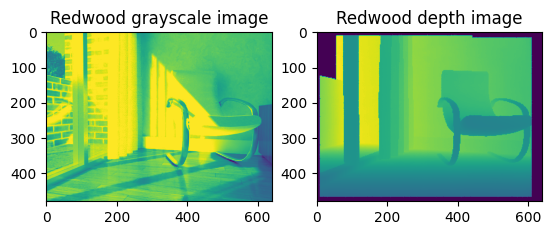

In [3]:

color_raw = o3d.io.read_image("RGBD_Data\\SampleRedwoodRGBDImages\\color\\00000.jpg")
depth_raw = o3d.io.read_image("RGBD_Data\\SampleFountainRGBDImages\\depth\\0000038-000001234662.png")

# color_raw = o3d.io.read_image("RGBD_Data\\SampleRedwoodRGBDImages\\color\\00000.jpg")
# depth_raw = o3d.io.read_image("RGBD_Data\\SampleRedwoodRGBDImages\\depth\\00000.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

### 转换为点云
在给定一组相机内参的情况下，RGBD图像可以被转换为点云。

In [5]:
# 从深度图生成点云
# 给定相机内参，默认内参
# 图像分辨率为640x480，焦距（fx, fy）=（525.0, 525.0），光学中心（cx, cy）=（319.5, 239.5）
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# 翻转，相机小孔成像
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 


### 可视化SUN数据集
建立RGBD的函数不一样

In [ ]:

color_raw = o3d.io.read_image("RGBD_Data\SampleSUNRGBDImage\SUN_color.jpg")
depth_raw = o3d.io.read_image("RGBD_Data\SampleSUNRGBDImage\SUN_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(
    color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('SUN grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('SUN depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

### 可视化NYU数据集
NYU数据集的图像不是标准的jpg或png格式，使用mpimg.imread来读取作为numpy数组的彩色图像并将其转换为Open3D图像

- 调用了一个辅助函数read_nyu_pgm，从纽约大学数据集中使用的特殊格式中读取深度图像
- 使用转换函数create_rgbd_image_from_nyu_format来解析SUN数据集中的深度图像



In [ ]:


# This is special function used for reading NYU pgm format
# as it is written in big endian byte order.
def read_nyu_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    img = np.frombuffer(buffer,
                        dtype=byteorder + 'u2',
                        count=int(width) * int(height),
                        offset=len(header)).reshape((int(height), int(width)))
    img_out = img.astype('u2')
    return img_out


print("Read NYU dataset")
# Open3D does not support ppm/pgm file yet. Not using o3d.io.read_image here.
# MathplotImage having some ISSUE with NYU pgm file. Not using imread for pgm.

color_raw = mpimg.imread("RGBD_Data\\SampleNYURGBDImage\\NYU_color.ppm")
depth_raw = read_nyu_pgm("RGBD_Data\\SampleNYURGBDImage\\NYU_depth.pgm")
color = o3d.geometry.Image(color_raw)
depth = o3d.geometry.Image(depth_raw)
rgbd_image = o3d.geometry.RGBDImage.create_from_nyu_format(color, depth)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('NYU grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('NYU depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

### 可视化TUM数据集
(官方文档下错数据集了)

使用转换函数create_rgbd_image_from_tum_format来解析TUM数据集中的深度图像

In [ ]:
color_raw = o3d.io.read_image("RGBD_Data\SampleTUMRGBDImage\TUM_color.png")
depth_raw = o3d.io.read_image("RGBD_Data\SampleTUMRGBDImage\TUM_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('TUM grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('TUM depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

## KD树
### 从点云建立DK树

In [ ]:

mesh = o3d.io.read_triangle_mesh("PointCloudData/yk_examples/TpipeMesh.ply")
pcd = mesh.sample_points_uniformly(number_of_points=5000)

# pcd = o3d.io.read_point_cloud("PointCloudData\\yk_examples\\TpipeMesh.ply")
pcd.paint_uniform_color([0.5, 0.5, 0.5])
pcd_tree = o3d.geometry.KDTreeFlann(pcd)

### 寻找相邻的点

In [ ]:
# 挑选第100个（数组以0为索引）点作为锚点，并将其涂成红色

pcd.colors[100] = [1, 0, 0]
o3d.visualization.draw_geometries([pcd])

#### KNN搜寻
返回锚点的k个最近的邻居的索引列表

In [ ]:
print("Find its 30 nearest neighbors, and paint them blue.")
[k, idx, _] = pcd_tree.search_knn_vector_3d(pcd.points[100], 30)
np.asarray(pcd.colors)[idx[1:], :] = [0, 0, 1]  # 涂蓝
o3d.visualization.draw_geometries([pcd])

#### 半径搜寻
返回与锚点距离小于给定半径的点

In [ ]:
print("Find its neighbors with distance less than 2, and paint them green.")
[k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[100], 2)
np.asarray(pcd.colors)[idx[1:], :] = [0, 1, 0]  # 涂绿
o3d.visualization.draw_geometries([pcd])

# 数据处理
## 文件IO
### 点云读写

In [ ]:
import open3d as o3d
import open3d_example as o3de
import numpy as np
import copy,time,re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# 读取和写入

pcd = o3d.io.read_point_cloud("PointCloudData\\yk_examples\\rectangle.ply")
print(pcd)
o3d.io.write_point_cloud("Cache\\copy_of_rectangle.pcd", pcd)

点云文件格式
|文件格式|描述|
|:-:|:-:|
|.xyz|每行是[x, y, z]，x,y,z是三维坐标|
|.xyzn|每行是[x, y, z, nx, ny, nz]，nx,ny,nz是法线坐标|
|.xyzrgb|每行是[x, y, z, r, g, b]，r,g,b的范围是[0, 1]|
|.pts|第一行是一个整数，表示点的个数。随后的行遵循以下格式之一:[x, y, z, i, r, g, b], [x, y, z, r, g, b], [x, y, z, i] or [x, y, z]|
|.ply|[参见Polygon File Format](http://paulbourke.net/dataformats/ply)，文件可以同时包含点云和网格数据|
|.pcd|[参见Point Cloud Data](http://pointclouds.org/documentation/tutorials/pcd_file_format.html)|

In [ ]:
# 也可以指定格式读取
# pcd = o3d.io.read_point_cloud("Cache\\copy_of_fragment.txt", format='xyz')

### mesh读写

In [ ]:
print("Testing IO for meshes ...")
mesh = o3d.io.read_triangle_mesh("PointCloudData\\yk_examples\\TpipeMesh.ply")
print(mesh)
o3d.visualization.draw_geometries([mesh])
o3d.io.write_triangle_mesh("Cache\\copy_of_TpipeMesh.ply", mesh,)


mesh文件格式
|文件格式|描述|
|:-:|:-:|
|.ply|[Polygon File Format](http://paulbourke.net/dataformats/ply)|
|.stl|[StereoLithography](http://www.fabbers.com/tech/STL_Format)|
|.obj|[Object Files](http://paulbourke.net/dataformats/obj/)|
|.off|[Object File Format](http://www.geomview.org/docs/html/OFF.html)|
|.gltf/.glb|[GL Transmission Format](https://github.com/KhronosGroup/glTF/tree/master/specification/2.0)|

### 图片读写

In [ ]:
print("Testing IO for images ...")
img = o3d.io.read_image("RGBD_Data\\SampleRedwoodRGBDImages\\color\\00000.jpg")
print(img)
o3d.io.write_image("Cache\\copy_of_Juneau.jpg", img)

## 转换numpy
Open3D的所有数据结构都与NumPy的缓冲区原生兼容。下面的教程使用NumPy生成了一个变体的同步函数，并使用Open3D将该函数可视化。

In [ ]:
# 生成一个n×3的矩阵xyz。每一列都有x、y和z的值，函数z=sin(x*x+y*y)/(x*x+y*y)。
# z_norm是[0,1]范围内z的归一化映射。
# Generate some neat n times 3 matrix using a variant of sync function
x = np.linspace(-3, 3, 401)
mesh_x, mesh_y = np.meshgrid(x, x)
z = np.sinc((np.power(mesh_x, 2) + np.power(mesh_y, 2)))
z_norm = (z - z.min()) / (z.max() - z.min())
xyz = np.zeros((np.size(mesh_x), 3))
xyz[:, 0] = np.reshape(mesh_x, -1)
xyz[:, 1] = np.reshape(mesh_y, -1)
xyz[:, 2] = np.reshape(z_norm, -1)
print('xyz')
print(xyz)


### 从NumPy到open3d.PointCloud
Open3D提供了从NumPy矩阵到3D向量的转换。通过使用Vector3dVector，一个NumPy矩阵可以直接被分配到open3d.PointCloud.points。

通过这种方式，任何类似的数据结构，如open3d.PointCloud.color或open3d.PointCloud.normals都可以使用NumPy进行分配或修改。

In [ ]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
# o3d.io.write_point_cloud("../../test_data/sync.ply", pcd)
o3d.visualization.draw_geometries([pcd])

### 从open3d.PointCloud到NumPy
类型为Vector3dVector的pcd_load.point使用np.asarray转换为NumPy数组

In [ ]:
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("PointCloudData\\yk_examples\\t_pipe_stackable.ply")

# Convert Open3D.o3d.geometry.PointCloud to numpy array
xyz_load = np.asarray(pcd_load.points)
print('xyz_load')
print(xyz_load)
o3d.visualization.draw_geometries([pcd_load])


## 点云离群点去除
### 准备输入数据

In [ ]:
pcd = o3d.io.read_point_cloud("PointCloudData\\isl-org_examples\\fragment.ply")
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.2,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])
# voxel_down_sample下采样
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.02)
o3d.visualization.draw_geometries([voxel_down_pcd],
                                  zoom=0.2,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


In [ ]:
# uniform_down_sample下采样
print("Every 5th points are selected")
uni_down_pcd = pcd.uniform_down_sample(every_k_points=5)
o3d.visualization.draw_geometries([uni_down_pcd],
                                  zoom=0.2,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


### 选择样本点
下面的辅助函数使用select_by_index，它接受一个二进制掩码，只输出选定的点。被选中的点和未被选中的点都是可视化的

In [ ]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])


### 统计离群点清除
statistical_outlier_removal删除那些与点云的平均数相比离其邻居较远的点。它需要两个输入参数：

- nb_neighbors，用于指定在计算一个给定点的平均距离时考虑多少个邻居。

- std_ratio，允许根据整个点云的平均距离的标准偏差来设置阈值水平。这个数字越小，过滤器就越积极。

In [ ]:
print("Statistical oulier removal")
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=2.0)
display_inlier_outlier(voxel_down_pcd, ind)


### 半径离群点去除

radius_outlier_removal删除那些在其周围给定范围内有少数邻居的点。有两个参数可以用来根据你的数据调整过滤器。

- nb_points，它让你选择球体应该包含的最小数量的点。

- radius，它定义了用于计算邻域的球体半径。

In [ ]:
print("Radius oulier removal")
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)


## 体素化
点云和三角网格是非常灵活，但不规则的几何类型。体素网格是3D的另一种几何类型，它被定义在一个规则的3D网格上，而体素可以被认为是2D中像素的3D对应物。Open3D有一个几何类型VoxelGrid，可以用来处理体素网格。
### 从mesh体素化
Open3D提供了create_from_triangle_mesh方法，可以从一个三角形网格中创建一个体素网格。它返回一个体素网格，其中所有与三角形相交的体素都被设置为1，其他都被设置为0。参数voxel_size定义了体素网格的分辨率。

In [ ]:

print('input')
mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\BunnyMesh.ply")

# fit to unit cube
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),
           center=mesh.get_center())
o3d.visualization.draw_geometries([mesh])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,
                                                              voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])


### 从点云体素化
使用create_from_point_cloud方法也可以从点云中创建体素网格。如果点云中至少有一个点在体素内，该体素就被占用。体素的颜色是该体素内所有点的平均值。参数voxel_size定义了体素网格的分辨率

In [ ]:
print('input')
mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\BunnyMesh.ply")

N = 2000
pcd = mesh.sample_points_poisson_disk(N)
# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])


### 包含性测试
体素网格也可以用来测试点是否在一个被占领的体素内。check_if_included方法接受一个(n,3)数组作为输入，并输出一个bool数组。

In [ ]:
queries = np.asarray(pcd.points)
output = voxel_grid.check_if_included(o3d.utility.Vector3dVector(queries))
print(output[:10])

### 体素雕琢
方法create_from_point_cloud和create_from_triangle_mesh只在几何体的表面创建占用的体素。然而，也可以从一些深度图或剪影中雕刻出一个体素网格。Open3D为体素雕刻提供了carve_depth_map和carve_silhouette方法。

In [ ]:
# 首先渲染几何体的深度图，然后使用这些深度图来雕刻一个密集的体素网格。其结果是给定形状的填充体素网格。
# 画球形
def xyz_spherical(xyz):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    r = np.sqrt(x * x + y * y + z * z)
    r_x = np.arccos(y / r)
    r_y = np.arctan2(z, x)
    return [r, r_x, r_y]


def get_rotation_matrix(r_x, r_y):
    rot_x = np.asarray([[1, 0, 0], [0, np.cos(r_x), -np.sin(r_x)],
                        [0, np.sin(r_x), np.cos(r_x)]])
    rot_y = np.asarray([[np.cos(r_y), 0, np.sin(r_y)], [0, 1, 0],
                        [-np.sin(r_y), 0, np.cos(r_y)]])
    return rot_y.dot(rot_x)


def get_extrinsic(xyz):
    rvec = xyz_spherical(xyz)
    r = get_rotation_matrix(rvec[1], rvec[2])
    t = np.asarray([0, 0, 2]).transpose()
    trans = np.eye(4)
    trans[:3, :3] = r
    trans[:3, 3] = t
    return trans


def preprocess(model):
    min_bound = model.get_min_bound()
    max_bound = model.get_max_bound()
    center = min_bound + (max_bound - min_bound) / 2.0
    scale = np.linalg.norm(max_bound - min_bound) / 2.0
    vertices = np.asarray(model.vertices)
    vertices -= center
    model.vertices = o3d.utility.Vector3dVector(vertices / scale)
    return model


def voxel_carving(mesh,
                  cubic_size,
                  voxel_resolution,
                  w=300,
                  h=300,
                  use_depth=True,
                  surface_method='pointcloud'):
    mesh.compute_vertex_normals()
    camera_sphere = o3d.geometry.TriangleMesh.create_sphere()

    # setup dense voxel grid
    voxel_carving = o3d.geometry.VoxelGrid.create_dense(
        width=cubic_size,
        height=cubic_size,
        depth=cubic_size,
        voxel_size=cubic_size / voxel_resolution,
        origin=[-cubic_size / 2.0, -cubic_size / 2.0, -cubic_size / 2.0],
        color=[1.0, 0.7, 0.0])

    # rescale geometry
    camera_sphere = preprocess(camera_sphere)
    mesh = preprocess(mesh)

    # setup visualizer to render depthmaps
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=w, height=h, visible=False)
    vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face = True
    ctr = vis.get_view_control()
    param = ctr.convert_to_pinhole_camera_parameters()

    # carve voxel grid
    pcd_agg = o3d.geometry.PointCloud()
    centers_pts = np.zeros((len(camera_sphere.vertices), 3))
    for cid, xyz in enumerate(camera_sphere.vertices):
        # get new camera pose
        trans = get_extrinsic(xyz)
        param.extrinsic = trans
        c = np.linalg.inv(trans).dot(np.asarray([0, 0, 0, 1]).transpose())
        centers_pts[cid, :] = c[:3]
        ctr.convert_from_pinhole_camera_parameters(param)

        # capture depth image and make a point cloud
        vis.poll_events()
        vis.update_renderer()
        depth = vis.capture_depth_float_buffer(False)
        pcd_agg += o3d.geometry.PointCloud.create_from_depth_image(
            o3d.geometry.Image(depth),
            param.intrinsic,
            param.extrinsic,
            depth_scale=1)

        # depth map carving method
        if use_depth:
            voxel_carving.carve_depth_map(o3d.geometry.Image(depth), param)
        else:
            voxel_carving.carve_silhouette(o3d.geometry.Image(depth), param)
        print("Carve view %03d/%03d" % (cid + 1, len(camera_sphere.vertices)))
    vis.destroy_window()

    # add voxel grid survace
    print('Surface voxel grid from %s' % surface_method)
    if surface_method == 'pointcloud':
        voxel_surface = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(
            pcd_agg,
            voxel_size=cubic_size / voxel_resolution,
            min_bound=(-cubic_size / 2, -cubic_size / 2, -cubic_size / 2),
            max_bound=(cubic_size / 2, cubic_size / 2, cubic_size / 2))
    elif surface_method == 'mesh':
        voxel_surface = o3d.geometry.VoxelGrid.create_from_triangle_mesh_within_bounds(
            mesh,
            voxel_size=cubic_size / voxel_resolution,
            min_bound=(-cubic_size / 2, -cubic_size / 2, -cubic_size / 2),
            max_bound=(cubic_size / 2, cubic_size / 2, cubic_size / 2))
    else:
        raise Exception('invalid surface method')
    voxel_carving_surface = voxel_surface + voxel_carving

    return voxel_carving_surface, voxel_carving, voxel_surface

if __name__ =="__main__":
    mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\BunnyMesh.ply")

    visualization = True
    cubic_size = 2.0
    voxel_resolution = 128.0

    voxel_grid, voxel_carving, voxel_surface = voxel_carving(
        mesh, cubic_size, voxel_resolution)


In [ ]:
print("surface voxels")
print(voxel_surface)
o3d.visualization.draw_geometries([voxel_surface])

print("carved voxels")
print(voxel_carving)
o3d.visualization.draw_geometries([voxel_carving])

print("combined voxels (carved + surface)")
print(voxel_grid)
o3d.visualization.draw_geometries([voxel_grid])


## 八叉树
八叉树是一种树形数据结构，每个内部节点有八个子节点。八叉树通常用于三维点云的空间划分。八角树的非空叶节点包含一个或多个属于同一空间分区的点。八叉树是对三维空间的一种有用的描述，可以用来快速找到附近的点。Open3D有一个几何类型的八叉树，可以用来创建、搜索和遍历八叉树，其最大的树深是用户指定的，max_depth。
### 从点云建立八叉树
一个八叉树可以通过使用转换方法（convert_from_point_cloud）从点云中构建。每个点都是按照从根节点到适当的叶节点的深度max_depth的路径插入树中的。随着树的深度增加，内部（最终是叶子）节点代表了三维空间的一个较小的分区。

如果点云有颜色，相应的叶子节点就采用最后插入的点的颜色。size_expand参数增加了根八叉树节点的大小，因此它比原始点云的边界略大，以容纳所有的点。

In [ ]:

print('input')
N = 2000
mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\BunnyMesh.ply")
pcd = mesh.sample_points_poisson_disk(N)
# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd])

print('octree division')
octree = o3d.geometry.Octree(max_depth=4)
octree.convert_from_point_cloud(pcd, size_expand=0.01)
o3d.visualization.draw_geometries([octree])


### 从体素建立八叉树
八叉树也可以使用create_from_voxel_grid方法从Open3D VoxelGrid几何体中构建。输入的VoxelGrid的每个体素被视为三维空间中的一个点，其坐标对应于体素的原点。每个叶子节点取其相应体素的颜色。

In [ ]:
print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

print('octree division')
octree = o3d.geometry.Octree(max_depth=4)
octree.create_from_voxel_grid(voxel_grid)
o3d.visualization.draw_geometries([octree])


### 遍历八叉树
八叉树可以被遍历，这对于搜索或处理三维几何体的子部分非常有用。通过为遍历方法提供一个回调，每次访问一个节点（内部或叶子）时，都可以进行额外的处理。

在下面的例子中，一个早期停止标准被用来只处理具有超过一定数量的点的内部/叶子节点。这种早期停止的能力可以用来有效地处理满足某些条件的空间区域。

In [ ]:

def f_traverse(node, node_info):
    early_stop = False

    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            n = 0
            for child in node.children:
                if child is not None:
                    n += 1
            print(
                "{}{}: Internal node at depth {} has {} children and {} points ({})"
                .format('    ' * node_info.depth,
                        node_info.child_index, node_info.depth, n,
                        len(node.indices), node_info.origin))

            # we only want to process nodes / spatial regions with enough points
            early_stop = len(node.indices) < 250
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            print("{}{}: Leaf node at depth {} has {} points with origin {}".
                  format('    ' * node_info.depth, node_info.child_index,
                         node_info.depth, len(node.indices), node_info.origin))
    else:
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop
octree = o3d.geometry.Octree(max_depth=4)
octree.convert_from_point_cloud(pcd, size_expand=0.01)
octree.traverse(f_traverse)


### 查找包含点的叶子节点

使用上述的遍历机制，可以在八叉树上快速搜索包含给定点的叶节点。这个功能是通过locate_leaf_node方法提供的。

也可以不遍历直接查找

In [ ]:
octree.locate_leaf_node(pcd.points[0])

## 表面重建 从点云重建mesh
在许多情况下，我们希望生成一个密集的三维几何体，即一个三角形的网格。然而，从多视角立体法或深度传感器中，我们只能得到一个非结构化的点云。为了从这个非结构化的输入中得到一个mesh，我们需要进行表面重建。在文献中，存在一些方法，Open3D目前实现了以下方法。

- Alpha shapes
- Ball pivoting
- Poisson surface reconstruction

### 阿尔法形状
阿尔法形状[Edelsbrunner1983]是凸面体的一个泛化。正如这里所描述的那样，人们可以直观地认为阿尔法形状是如下的。想象一下，有一大团冰淇淋，其中的点S是硬巧克力块。使用这些球形的冰淇淋勺子，我们在不撞到巧克力块的情况下，将冰淇淋块的所有部分都雕刻出来，从而甚至在内部雕刻出洞（例如，简单地从外面移动勺子所不能到达的部分）。我们最终会得到一个由帽、弧和点围成的（不一定是凸的）物体。如果我们现在把所有的圆面都拉直成三角形和线段，我们就有了一个直观的描述，即所谓的S的阿尔法形状。

Open3D实现了涉及权衡参数α的方法create_from_point_cloud_alpha_shape。

In [ ]:
mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\BunnyMesh.ply")
mesh.compute_vertex_normals()
pcd = mesh.sample_points_poisson_disk(750)
o3d.visualization.draw_geometries([pcd])
alpha = 0.03
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

这个实现是基于点云的凸包。如果我们想从一个给定的点云中计算出多个alpha形状，那么我们可以只计算一次凸包，并将其传递给create_from_point_cloud_alpha_shape，从而节省一些计算量。

In [ ]:
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
for alpha in np.logspace(np.log10(0.5), np.log10(0.01), num=4):
    print(f"alpha={alpha:.3f}")
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
        pcd, alpha, tetra_mesh, pt_map)
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)


### 球体透视

球状旋转算法（BPA）[Bernardini1999]是一种与阿尔法形状有关的表面重建方法。直观地讲，想想一个有一定半径的三维球，我们把它放在点云上。如果它击中了任何3个点（并且它没有落过这3个点），它就会产生一个三角形。然后，算法从现有三角形的边缘开始转动，每当它击中3个球没有落下的点时，我们就创建一个新的三角形。

Open3D在create_from_point_cloud_ball_pivoting中实现了这个方法。该方法接受一个半径列表作为参数，对应于在点云上旋转的各个球的半径。

**注意:这个算法假设点云有法线。**

In [ ]:
gt_mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\BunnyMesh.ply")
gt_mesh.compute_vertex_normals()
pcd = gt_mesh.sample_points_poisson_disk(3000)
# pcd = o3d.io.read_point_cloud("PointCloudData\\isl-org_examples\\EaglePointCloud.ply")
o3d.visualization.draw_geometries([pcd])
radii = [0.005, 0.01, 0.02, 0.04]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
o3d.visualization.draw_geometries([pcd, rec_mesh])


### 泊松曲面重建

泊松曲面重建方法[Kazhdan2006]解决了一个规则化的优化问题，以获得一个光滑的曲面。由于这个原因，泊松曲面重建可以优于上面提到的方法，因为它们产生了非光滑的结果，因为PointCloud的点也是产生的三角形网格的顶点，不需要任何修改。

Open3D实现了create_from_point_cloud_poisson方法，它基本上是Kazhdan代码的一个封装。该函数的一个重要参数是深度，它定义了用于表面重建的八叉树的深度，从而意味着生成的三角形网格的分辨率。一个较高的深度值意味着网格有更多的细节。

**注意:这个算法假设PointCloud有normals。**

In [ ]:

pcd = o3d.io.read_point_cloud("PointCloudData\\isl-org_examples\\EaglePointCloud.ply")
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])


In [ ]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])


泊松曲面重建也会在点密度低的区域创建三角形，甚至会外推到一些区域（见上面老鹰输出的底部）。create_from_point_cloud_poisson函数有第二个densities返回值，表示每个顶点的密度。一个低密度值意味着该顶点仅由输入点云中的低数量的点支持。

在下面的代码中，我们用伪色将密度在三维中可视化。紫色表示低密度，黄色表示高密度。

In [ ]:

print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])


我们可以进一步使用密度值来移除支持度低的顶点和三角形。在下面的代码中，我们删除所有密度值低于所有密度值的0.01四分位数的顶点（和连接的三角形）

In [ ]:
print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])


### 法线估计
在上面的例子中，我们假设点云的法线是向外指向的。然而，并不是所有的点云都已经有了相关的法线。Open3D可以用improve_normals来估计点云的法线，它对每个3D点进行局部拟合以得出法线。然而，估计的法线可能不是一致的方向。 orient_normals_consistent_tangent_plane使用最小生成树传播法线方向。

In [ ]:

gt_mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\BunnyMesh.ply")

pcd = gt_mesh.sample_points_poisson_disk(5000)
pcd.normals = o3d.utility.Vector3dVector(np.zeros(
    (1, 3)))  # invalidate existing normals

pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd], point_show_normal=True)


In [ ]:
pcd.orient_normals_consistent_tangent_plane(100)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

## 点云变换
平移、旋转、缩放和一般变换
### 平移
平移方法接受一个单一的三维矢量t作为输入，并通过这个矢量平移几何体的所有点/顶点，vt=v+t。下面的代码显示了网格是如何在X方向和Y方向上平移一次的。

In [ ]:

mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
# mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh_tx = copy.deepcopy(mesh).translate((1.3, 0, 0))
mesh_ty = copy.deepcopy(mesh).translate((0, 1.3, 0))
# 注意:get_center方法返回TriangleMesh顶点的平均值。
# 这意味着，对于在原点[0,0,0]创建的坐标框架，
# get_center将返回[0.05167549 0.05167549 0.05167549]。
print(f'Center of mesh: {mesh.get_center()}')
print(f'Center of mesh tx: {mesh_tx.get_center()}')
print(f'Center of mesh ty: {mesh_ty.get_center()}')
o3d.visualization.draw_geometries([mesh, mesh_tx, mesh_ty])


该方法需要一个相对的第二个参数，默认设置为True。如果设置为False，几何体的中心会被直接翻译到第一个参数中指定的位置。

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_mv = copy.deepcopy(mesh).translate((2, 2, 2), relative=False)
print(f'Center of mesh: {mesh.get_center()}')
print(f'Center of translated mesh: {mesh_mv.get_center()}')
o3d.visualization.draw_geometries([mesh, mesh_mv])

### 旋转
Open3D的几何体类型也可以用旋转的方法进行旋转。它需要一个旋转矩阵R作为第一个参数。由于3D中的旋转可以用多种方式进行参数化，Open3D提供了方便的函数来将不同的参数化转换为旋转矩阵。

- 用get_rotation_matrix_from_xyz转换欧拉角（其中xyz也可以是yzx、zxy、xzy、zyx和yxz形式）。

- 用get_rotation_matrix_from_axis_angle转换轴-角表示法。

- 用get_rotation_matrix_from_quaternion转换四元数。

在下面的代码中，我们使用欧拉角来旋转网格

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_r = copy.deepcopy(mesh)
R = mesh.get_rotation_matrix_from_xyz((np.pi / 3, 0, 0))
mesh_r.rotate(R, center=(0, 0, 0))
o3d.visualization.draw_geometries([mesh, mesh_r])

函数rotate有一个第二个参数center，默认设置为True。这表明在应用旋转之前，对象首先被置于中心位置，然后再移回其先前的中心。如果这个参数设置为False，那么旋转将被直接应用，这样整个几何体将围绕坐标中心旋转。这意味着网格中心在旋转后可以被改变。

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_r = copy.deepcopy(mesh).translate((2, 0, 0))
mesh_r.rotate(mesh.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi / 4)),
              center=(0, 0, 2))
o3d.visualization.draw_geometries([mesh, mesh_r])

### 缩放
Open3D几何体类型的顶点和点也可以使用比例，vs=s⋅v进行缩放

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_s = copy.deepcopy(mesh).translate((2, 0, 0))
mesh_s.scale(0.5, center=mesh_s.get_center())
o3d.visualization.draw_geometries([mesh, mesh_s])

缩放方法还有一个第二个参数center，默认设置为True。如果它被设置为 "False"，那么在缩放之前，对象不会被置于中心位置，这样对象的中心就会因为缩放操作而移动。

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_s = copy.deepcopy(mesh).translate((2, 1, 0))
mesh_s.scale(0.5, center=(0, 0, 0))
o3d.visualization.draw_geometries([mesh, mesh_s])

### 一般变换
Open3D也支持由一个4×4的同质变换矩阵定义的一般变换，使用变换方法。

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
T = np.eye(4)
T[:3, :3] = mesh.get_rotation_matrix_from_xyz((0, np.pi / 3, np.pi / 2))
T[0, 3] = 1
T[1, 3] = 1.3
print(T)
mesh_t = copy.deepcopy(mesh).transform(T)
o3d.visualization.draw_geometries([mesh, mesh_t])

## mesh 变换
deform_as_rigid_as_possible中实现了这个方法。

第一个参数是一组constraint_ids，指的是三角形网格中的顶点。

第二个参数constrint_pos定义了这些顶点在优化后应该处于哪个位置。

优化过程是一个迭代方案。因此，我们也可以通过max_iter定义迭代的次数。

In [ ]:


mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\ArmadilloMesh.ply")
# armadillo = o3d.data.ArmadilloMesh()
# mesh = o3d.io.read_triangle_mesh(armadillo.path)

vertices = np.asarray(mesh.vertices)
static_ids = [idx for idx in np.where(vertices[:, 1] < -30)[0]]
static_pos = []
for id in static_ids:
    static_pos.append(vertices[id])
handle_ids = [2490]
handle_pos = [vertices[2490] + np.array((-40, -40, -40))]
constraint_ids = o3d.utility.IntVector(static_ids + handle_ids)
constraint_pos = o3d.utility.Vector3dVector(static_pos + handle_pos)

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_prime = mesh.deform_as_rigid_as_possible(constraint_ids,
                                                  constraint_pos,
                                                  max_iter=50)

In [ ]:
print('Original Mesh')
R = mesh.get_rotation_matrix_from_xyz((0, np.pi, 0))
o3d.visualization.draw_geometries([mesh.rotate(R, center=mesh.get_center())])
print('Deformed Mesh')
mesh_prime.compute_vertex_normals()
o3d.visualization.draw_geometries(
    [mesh_prime.rotate(R, center=mesh_prime.get_center())])

## 内部形状描述子(ISS关键点检测)


In [ ]:

# Compute ISS Keypoints on ArmadilloMesh
mesh = o3d.io.read_triangle_mesh("PointCloudData\isl-org_examples\ArmadilloMesh.ply")
mesh.compute_vertex_normals()

pcd = o3d.geometry.PointCloud()
pcd.points = mesh.vertices

tic = time.time()
keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd)
toc = 1000 * (time.time() - tic)
print("ISS Computation took {:.0f} [ms]".format(toc))

mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5, 0.5, 0.5])
keypoints.paint_uniform_color([1.0, 0.75, 0.0])
o3d.visualization.draw_geometries([keypoints, mesh])


In [ ]:
# This function is only used to make the keypoints look better on the rendering
def keypoints_to_spheres(keypoints):
    spheres = o3d.geometry.TriangleMesh()
    for keypoint in keypoints.points:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.001)
        sphere.translate(keypoint)
        spheres += sphere
    spheres.paint_uniform_color([1.0, 0.75, 0.0])
    return spheres
# Compute ISS Keypoints on Standford BunnyMesh, changing the default parameters

mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\BunnyMesh.ply")
mesh.compute_vertex_normals()

pcd = o3d.geometry.PointCloud()
pcd.points = mesh.vertices

tic = time.time()
keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd,
                                                        salient_radius=0.005,
                                                        non_max_radius=0.005,
                                                        gamma_21=0.5,
                                                        gamma_32=0.5)
toc = 1000 * (time.time() - tic)
print("ISS Computation took {:.0f} [ms]".format(toc))

mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([keypoints_to_spheres(keypoints), mesh])


## 光线照射
Open3D中的RaycastingScene类提供了基本的光线投射功能。在本教程中，我们将展示如何创建一个场景并进行光线相交测试。你也可以使用RaycastingScene从网格中创建一个虚拟点云，例如从CAD模型中创建。

In [ ]:
# 创建mesh
cube = o3d.geometry.TriangleMesh.create_box().translate([0, 0, 0])
cube = o3d.t.geometry.TriangleMesh.from_legacy(cube)
# 创建场景 添加mesh
scene = o3d.t.geometry.RaycastingScene()
cube_id = scene.add_triangles(cube)
print(cube_id)

In [ ]:
# 创建两道光线
# 第一道光线从 (0.5,0.5,10) 照射到 (0,0,-1).
# 第二道光线从 (-1,-1,-1) 照射到 (0,0,-1).
rays = o3d.core.Tensor([[0.5, 0.5, 10, 0, 0, -1], [-1, -1, -1, 0, 0, -1]],
                       dtype=o3d.core.Dtype.Float32)

ans = scene.cast_rays(rays)
print(ans.keys())
# t_hit是到交点的距离。单位是由射线方向的长度定义的。如果没有相交点，则为Inf
# geometry_ids给出被射线击中的几何体的ID。如果没有击中几何体，则为RaycastingScene.INVALID_ID。
# primitive_ids是被击中的三角形的索引或RaycastingScene.INVALID_ID。
# primitive_uvs是三角形内交点的arycentric坐标。
# primitive_normals是被击中的三角形的法线。
print(ans['t_hit'].numpy(), ans['geometry_ids'].numpy())


In [ ]:
# 创建有多个对象的场景
# Create meshes and convert to open3d.t.geometry.TriangleMesh
cube = o3d.geometry.TriangleMesh.create_box().translate([0, 0, 0])
cube = o3d.t.geometry.TriangleMesh.from_legacy(cube)
torus = o3d.geometry.TriangleMesh.create_torus().translate([0, 0, 2])
torus = o3d.t.geometry.TriangleMesh.from_legacy(torus)
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5).translate(
    [1, 2, 3])
sphere = o3d.t.geometry.TriangleMesh.from_legacy(sphere)

scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(cube)
scene.add_triangles(torus)
_ = scene.add_triangles(sphere)

RaycastingScene允许用任意数量的前导尺寸来组织射线。例如，我们可以生成一个形状为[h,w,6]的数组来组织射线以创建一个图像。该类还提供了为针孔摄像机创建射线的辅助函数。以下是创建形状为[480,640,6]的射线张量。

In [ ]:
# 创建射线张量
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[0, 0, 2],
    eye=[2, 3, 0],
    up=[0, 1, 0],
    width_px=640,
    height_px=480,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)

In [ ]:
# 输出的张量保留了射线的形状，我们可以用matplotlib直接将命中距离可视化，得到深度图

plt.imshow(ans['t_hit'].numpy())

In [ ]:
# 可视化原始法线
# use abs to avoid negative values
plt.imshow(np.abs(ans['primitive_normals'].numpy()))

In [ ]:
# 可视化被光线击中的目标
plt.imshow(ans['geometry_ids'].numpy(), vmax=3)

### 从射线照射中创建虚拟点云
使用击中距离来计算交点的XYZ坐标。这些是你通过在射线的原点放置一个虚拟的三维传感器而得到的点。

In [ ]:
hit = ans['t_hit'].isfinite()
points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
pcd = o3d.t.geometry.PointCloud(points)
# Press Ctrl/Cmd-C in the visualization window to copy the current viewpoint
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  front=[0.5, 0.86, 0.125],
                                  lookat=[0.23, 0.5, 2],
                                  up=[-0.63, 0.45, -0.63],
                                  zoom=0.7)
# o3d.visualization.draw([pcd]) # new API



## 距离查询
Open3D中的RaycastingScene类提供了一组距离查询，它可以用来将mesh转换为隐式函数，查询到表面的距离或确定一个点是否在网格内。
### mesh转换为隐式表达

In [ ]:

# 初始化，用一个（封闭的）mesh初始化一个RaycastingScene
# Load mesh and convert to open3d.t.geometry.TriangleMesh
mesh = o3d.io.read_triangle_mesh("PointCloudData\\isl-org_examples\\ArmadilloMesh.ply")
mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(mesh)  # we do not need the geometry ID for mesh


### 计算单点的距离和mesh内外

In [ ]:
# RaycastingScene直接提供函数来计算 一个点到mesh表面的无符号和有符号距离。
# 它还提供了一个函数来计算一个查询点的占用率。
query_point = o3d.core.Tensor([[10, 10, 10]], dtype=o3d.core.Dtype.Float32)

# Compute distance of the query point from the surface
unsigned_distance = scene.compute_distance(query_point)
signed_distance = scene.compute_signed_distance(query_point)
occupancy = scene.compute_occupancy(query_point)
# 虽然无符号的距离总是可以计算出来，
# 但有符号的距离和占用率只有在mesh不漏水且内部和外部都明确定义的情况下才有效。
# 如果查询点在mesh内，则有符号距离为负值。占用率对于网格外的点是0，对于网格内的点是1。

In [ ]:
# 我们的网格是不漏水的，我们可以看到查询点是在网格内，因为有符号的距离和占用率的值。
print("unsigned distance", unsigned_distance.numpy())
print("signed_distance", signed_distance.numpy())
print("occupancy", occupancy.numpy())

### 计算多个点和mesh的距离
RaycastingScene允许一次进行多个查询。例如，我们可以通过一个具有N个查询点的[N,3]张量，该张量可用于随机抽样，以训练机器学习中的隐性神经表征。

In [ ]:

min_bound = mesh.vertex['positions'].min(0).numpy()
max_bound = mesh.vertex['positions'].max(0).numpy()

N = 256
query_points = np.random.uniform(low=min_bound, high=max_bound,
                                 size=[N, 3]).astype(np.float32)

# Compute the signed distance for N random points
signed_distance = scene.compute_signed_distance(query_points)


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(query_points)
o3d.visualization.draw_geometries([pcd])

In [ ]:

xyz_range = np.linspace(min_bound, max_bound, num=32)

# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

# signed distance is a [32,32,32] array
signed_distance = scene.compute_signed_distance(query_points)

# We can visualize a slice of the distance field directly with matplotlib
plt.imshow(signed_distance.numpy()[:, :, 10])


### 最近点查询计算距离
距离函数是建立在compute_closest_points()函数之上的。在这一部分，我们将重新实现有符号距离，并展示如何利用compute_closest_points()函数返回的额外信息。

In [ ]:
# 初始化
# 首先初始化一个带有两个三角形网格的RaycastingScene。
# 这两个网格都是不漏水的，我们将把它们放置在它们之间没有交集的地方。

cube = o3d.t.geometry.TriangleMesh.from_legacy(
    o3d.geometry.TriangleMesh.create_box().translate([-1.2, -1.2, 0]))
sphere = o3d.t.geometry.TriangleMesh.from_legacy(
    o3d.geometry.TriangleMesh.create_sphere(0.5).translate([0.7, 0.8, 0]))

scene = o3d.t.geometry.RaycastingScene()
# Add triangle meshes and remember ids
mesh_ids = {}
mesh_ids[scene.add_triangles(cube)] = 'cube'
mesh_ids[scene.add_triangles(sphere)] = 'sphere'


In [ ]:
# 创建射线张量
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[0, 0, 2],
    eye=[2, 3, 0],
    up=[0, 1, 0],
    width_px=640,
    height_px=480,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)

In [ ]:
# 从射线中创建虚拟点云
hit = ans['t_hit'].isfinite()
points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
pcd = o3d.t.geometry.PointCloud(points)
# Press Ctrl/Cmd-C in the visualization window to copy the current viewpoint
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  front=[0.5, 0.86, 0.125],
                                  lookat=[0.23, 0.5, 2],
                                  up=[-0.63, 0.45, -0.63],
                                  zoom=0.7)

In [ ]:
# 计算曲面上最近的点
# RaycastingScene.compute_closest_points()可以计算曲面上与查询点最近的点。


query_point = o3d.core.Tensor([[0, 0, 0]], dtype=o3d.core.Dtype.Float32)

# We compute the closest point on the surface for the point at position [0,0,0].
ans = scene.compute_closest_points(query_point)

# Compute_closest_points provides the point on the surface, the geometry id,
# and the primitive id.
# The dictionary keys are
#.    points
#.    geometry_ids
#.    primitive_ids
print('The closest point on the surface is', ans['points'].numpy())
print('The closest point is on the surface of the',
      mesh_ids[ans['geometry_ids'][0].item()])
print('The closest point belongs to triangle', ans['primitive_ids'][0].item())


In [ ]:
# 为了计算该点是在内部还是外部，我们可以从查询点开始投射一条射线，然后计算交点的数量
rays = np.concatenate(
    [query_point.numpy(),
     np.ones(query_point.shape, dtype=np.float32)],
    axis=-1)
intersection_counts = scene.count_intersections(rays).numpy()
# A point is inside if the number of intersections with the scene is even
# This sssumes that inside and outside is we ll defined for the scene.
is_inside = intersection_counts % 2 == 1
print(is_inside)

In [ ]:
# 可以将其合并为一个函数，创建一个特殊的带符号的距离函数，并返回额外的信息
def compute_signed_distance_and_closest_goemetry(query_points: np.ndarray):
    closest_points = scene.compute_closest_points(query_points)
    distance = np.linalg.norm(query_points - closest_points['points'].numpy(),
                              axis=-1)
    rays = np.concatenate([query_points, np.ones_like(query_points)], axis=-1)
    intersection_counts = scene.count_intersections(rays).numpy()
    is_inside = intersection_counts % 2 == 1
    distance[is_inside] *= -1
    return distance, closest_points['geometry_ids'].numpy()

In [ ]:
# 可以用这个函数来创建一个带有距离和几何id信息的网格
# compute range
xyz_range = np.linspace([-2, -2, -2], [2, 2, 2], num=32)
# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

sdf, closest_geom = compute_signed_distance_and_closest_goemetry(query_points)

# We can visualize a slice of the grids directly with matplotlib
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sdf[:, :, 16])
axes[1].imshow(closest_geom[:, :, 16])
